## Download the necessary package and files.

In [ ]:
!pip3 install mtcnn
!git clone https://github.com/ipazc/mtcnn.git
!wget clone https://github.com/satinder147/Attendance-using-Face/raw/master/facenet_keras.h5

     |████████████████████████████████| 2.3MB 12.5MB/s 
Cloning into 'mtcnn'...
remote: Enumerating objects: 24, done.
remote: Counting objects: 100% (24/24), done.
remote: Compressing objects: 100% (22/22), done.
remote: Total 218 (delta 7), reused 10 (delta 2), pack-reused 194
Receiving objects: 100% (218/218), 2.82 MiB | 20.04 MiB/s, done.
Resolving deltas: 100% (111/111), done.
--2021-03-16 07:29:15--  http://clone/
Resolving clone (clone)... failed: Name or service not known.
wget: unable to resolve host address ‘clone’
--2021-03-16 07:29:15--  https://github.com/satinder147/Attendance-using-Face/raw/master/facenet_keras.h5
Resolving github.com (github.com)... 140.82.121.4
Connecting to github.com (github.com)|140.82.121.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/satinder147/Attendance-using-Face/master/facenet_keras.h5 [following]
--2021-03-16 07:29:15--  https://raw.githubusercontent.com/satinder147/Attendan

In [ ]:
# Download the dataset from Kaggle by using API
!mkdir /root/.kaggle
!echo '{"username":"jasonxu95","key":"e4b2cf60fd7b4fdadce64ca2839be937"}' > /root/.kaggle/kaggle.json
!kaggle datasets download -d dansbecker/5-celebrity-faces-dataset

 99% 5.00M/5.03M [00:00<00:00, 15.6MB/s]
100% 5.03M/5.03M [00:00<00:00, 14.4MB/s]


In [ ]:
# unzip the dataset
!unzip /content/5-celebrity-faces-dataset.zip

Archive:  /content/5-celebrity-faces-dataset.zip
  inflating: data/train/ben_afflek/httpcsvkmeuaeccjpg.jpg  
  inflating: data/train/ben_afflek/httpimagesfandangocomrImageRendererredesignstaticimgnoxportraitjpgpcpcpcimagesmasterrepositoryperformerimagespjpg.jpg  
  inflating: data/train/ben_afflek/httpssmediacacheakpinimgcomxdbbdbbbececacdecdcdfjpg.jpg  
  inflating: data/train/ben_afflek/httpssmediacacheakpinimgcomxdfdfadcfeabjpg.jpg  
  inflating: data/train/ben_afflek/httpssmediacacheakpinimgcomxedaedabcbefbcbabbjpg.jpg  
  inflating: data/train/ben_afflek/httpssmediacacheakpinimgcomxeebdfdbaaajpg.jpg  
  inflating: data/train/ben_afflek/httpssmediacacheakpinimgcomxeeedcacddeccccacfjpg.jpg  
  inflating: data/train/ben_afflek/httpsuploadwikimediaorgwikipediacommonsthumbddBenAffleckbyGageSkidmorejpgpxBenAffleckbyGageSkidmorejpg.jpg  
  inflating: data/train/ben_afflek/httptrwebimgacstanetcxbdddmediasnmediajpg.jpg  
  inflating: data/train/ben_afflek/httpwwwaceshowbizcomimagesphotoben

## Load the packages.

In [ ]:
# face detection for the 5 Celebrity Faces Dataset
from os import listdir
from os.path import isdir
from PIL import Image
from matplotlib import pyplot
import numpy as np

from numpy import savez_compressed
from numpy import asarray
from numpy import load
from numpy import expand_dims

from mtcnn.mtcnn import MTCNN
from keras.models import load_model

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import Normalizer

import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

### Extract face and create dataset

1 (160, 160, 3)
2 (160, 160, 3)
3 (160, 160, 3)
4 (160, 160, 3)
5 (160, 160, 3)
6 (160, 160, 3)
7 (160, 160, 3)
8 (160, 160, 3)
9 (160, 160, 3)
10 (160, 160, 3)
11 (160, 160, 3)
12 (160, 160, 3)
13 (160, 160, 3)
14 (160, 160, 3)


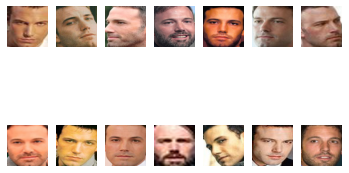

In [ ]:
# extract a single face from a given photograph
def extract_face(filename, required_size=(160, 160)):
	# load image from file
	image = Image.open(filename)
	# convert to RGB, if needed
	image = image.convert('RGB')
	# convert to array
	pixels = asarray(image)
	# create the detector, using default weights
	detector = MTCNN()
	# detect faces in the image
	results = detector.detect_faces(pixels)
	# extract the bounding box from the first face
	x1, y1, width, height = results[0]['box']
	# bug fix
	x1, y1 = abs(x1), abs(y1)
	x2, y2 = x1 + width, y1 + height
	# extract the face
	face = pixels[y1:y2, x1:x2]
	# resize pixels to the model size
	image = Image.fromarray(face)
	image = image.resize(required_size)
	face_array = asarray(image)
	return face_array
 
# specify folder to plot
folder = '/content/train/ben_afflek/'
i = 1
# enumerate files
for filename in listdir(folder):
	# path
	path = folder + filename
	# get face
	face = extract_face(path)
	print(i, face.shape)
	# plot
	pyplot.subplot(2, 7, i)
	pyplot.axis('off')
	pyplot.imshow(face)
	i += 1
pyplot.show()

In [ ]:
# load images and extract faces for all images in a directory
def load_faces(directory):
	faces = list()
	# enumerate files
	for filename in listdir(directory):
		# path
		path = directory + filename
		# get face
		face = extract_face(path)
		# store
		faces.append(face)
	return faces


# load a dataset that contains one subdir for each class that in turn contains images
def load_dataset(directory):
    X, y = list(), list()
    # enumerate folders, on per class
    for subdir in listdir(directory):
        # path
        path = directory + subdir + '/'
        # skip any files that might be in the dir
        if not isdir(path):
          continue
        # load all faces in the subdirectory
        faces = load_faces(path)
        # create labels
        labels = [subdir for _ in range(len(faces))]
        # summarize progress
        print('>loaded %d/%d examples for class: %s' % (len(faces), len(listdir(path)),subdir))
        # store
        X.extend(faces)
        y.extend(labels)
    return asarray(X), asarray(y)

In [ ]:
# load train dataset
trainX, trainy = load_dataset('train/')
print(trainX.shape, trainy.shape)
# load test dataset
testX, testy = load_dataset('val/')
print(testX.shape, testy.shape)
# save arrays to one file in compressed format
savez_compressed('processed-dataset.npz', trainX, trainy, testX, testy)

>loaded 14/14 examples for class: ben_afflek
>loaded 19/19 examples for class: madonna
>loaded 21/21 examples for class: jerry_seinfeld
>loaded 22/22 examples for class: mindy_kaling
>loaded 17/17 examples for class: elton_john
(93, 160, 160, 3) (93,)
>loaded 5/5 examples for class: ben_afflek
>loaded 5/5 examples for class: madonna
>loaded 5/5 examples for class: jerry_seinfeld
>loaded 5/5 examples for class: mindy_kaling
>loaded 5/5 examples for class: elton_john
(25, 160, 160, 3) (25,)


## Create Face Embeddings

In [ ]:
# get the face embedding for one face
def get_embedding(model, face_pixels):
	# scale pixel values
	face_pixels = face_pixels.astype('float32')
	# standardize pixel values across channels (global)
	mean, std = face_pixels.mean(), face_pixels.std()
	face_pixels = (face_pixels - mean) / std
	# transform face into one sample
	samples = expand_dims(face_pixels, axis=0)
	# make prediction to get embedding
	yhat = model.predict(samples)
	return yhat[0]

In [ ]:
# load the face dataset
data = load('processed-dataset.npz')
trainX, trainy, testX, testy = data['arr_0'], data['arr_1'], data['arr_2'], data['arr_3']
print('Loaded: ', trainX.shape, trainy.shape, testX.shape, testy.shape)

# load the facenet model
model = load_model('facenet_keras.h5')
# summarize input and output shape
print(model.inputs)
print(model.outputs)
print('Loaded Model')


Loaded:  (93, 160, 160, 3) (93,) (25, 160, 160, 3) (25,)
[<KerasTensor: shape=(None, 160, 160, 3) dtype=float32 (created by layer 'input_1')>]
[<KerasTensor: shape=(None, 128) dtype=float32 (created by layer 'Bottleneck_BatchNorm')>]
Loaded Model


In [ ]:
# convert each face in the train set to an embedding
newTrainX = list()
for face_pixels in trainX:
	embedding = get_embedding(model, face_pixels)
	newTrainX.append(embedding)
 
newTrainX = asarray(newTrainX)
print(newTrainX.shape)

# convert each face in the test set to an embedding
newTestX = list()
for face_pixels in testX:
	embedding = get_embedding(model, face_pixels)
	newTestX.append(embedding)
newTestX = asarray(newTestX)
print(newTestX.shape)

(93, 128)
(25, 128)


In [ ]:
newTestX[0].shape

(128,)

In [ ]:
# save arrays to one file in compressed format
savez_compressed('faces-embeddings.npz', newTrainX, trainy, newTestX, testy)

## Perform Face Classification

In [ ]:
# load dataset
data = load('faces-embeddings.npz')
trainX, trainy, testX, testy = data['arr_0'], data['arr_1'], data['arr_2'], data['arr_3']
print('Dataset: train=%d, test=%d' % (trainX.shape[0], testX.shape[0]))

Dataset: train=93, test=25


In [ ]:
# normalize input vectors
# in_encoder = Normalizer(norm='l2')
# trainX = in_encoder.transform(trainX)
# testX = in_encoder.transform(testX)

In [ ]:
# label encode targets
out_encoder = LabelEncoder()
out_encoder.fit(trainy)
trainy = out_encoder.transform(trainy)
testy = out_encoder.transform(testy)

## perform one-shot learning

In [ ]:
# predict the text img label
y_pred = []
for test_img in testX:
  dist_list = []
  for train_img in trainX:
    # cal L2 distance
    dist = np.linalg.norm(test_img - train_img)
    dist_list.append(dist)
  predict_label = trainy[np.argmin(dist_list)]
  y_pred.append(predict_label)

In [ ]:
# define a score function to calculate the accuracy.
def score(y_pred, y_test):
    
    score = (sum(y_pred == y_test)/ len(y_test))*100
        
    return score

In [ ]:
score(y_pred, testy)

100.0

In [ ]:
def load_dataset(directory):
    X, y = list(), list()
    # enumerate folders, on per class
    for subdir in listdir(directory):
        # path
        path = directory + subdir + '/'
        # skip any files that might be in the dir
        if not isdir(path):
          continue
        # load all faces in the subdirectory
        faces = load_faces(path)
        # create labels
        labels = [subdir for _ in range(len(faces))]
        # summarize progress
        print('>loaded %d/%d examples for class: %s' % (len(faces), len(listdir(path)),subdir))
        # store
        X.extend(faces)
        y.extend(labels)
    return asarray(X), asarray(y)

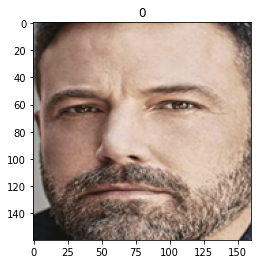

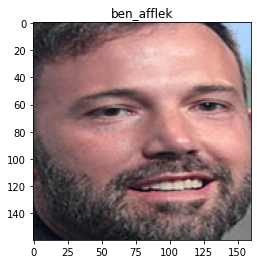

In [ ]:
# try some other pics
import math
path = '/content/ben.PNG'
face_array = extract_face(path)
dummy_embedding = get_embedding(model, face_array)

dist_list = []
for train_img in trainX:
    # cal L2 distance
    dist = np.linalg.norm(dummy_embedding - train_img)
    dist_list.append(dist)

# predict the result
indx = np.argmin(dist_list)
predict_label = trainy[indx]

# plot for fun
pyplot.imshow(face_array)
title = '%s' % (predict_label)
pyplot.title(title)
pyplot.show()

data = load('processed-dataset.npz')
X, y, _, _ = data['arr_0'], data['arr_1'], data['arr_2'], data['arr_3']
pyplot.imshow(X[indx])
title = '%s' % (y[indx])
pyplot.title(title)
pyplot.show()